In [32]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import matplotlib.pyplot as plt
import re
import pandas as pd
from pathlib import Path
import torch

from fastprogress import master_bar, progress_bar
%config InlineBackend.figure_format ='retina'

In [1]:
import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
def gem(x, p=3, eps=1e-5):
    return torch.abs(F.avg_pool2d(x.clamp(min=eps, max=1e4).pow(p), (x.size(-2), x.size(-1))).pow(1./p))
class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm,self).__init__()
        self.eps = 1e-10
    def forward(self, x):
        norm = torch.sqrt(torch.sum(x * x, dim = 1) + self.eps)
        x= x / norm.unsqueeze(1).expand_as(x)
        return x

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=torch.clamp(self.p, min=0.1), eps=self.eps)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class RingHead(nn.Module):
    def __init__(self, num_classes, feat_dim, in_feat = 1024, r_init =1.5):
        super(RingHead,self).__init__()
        self.eps = 1e-10
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.feature_extractor = nn.Sequential(
                        nn.ReLU(),
                        GeM(3.74), Flatten(),
                        nn.BatchNorm1d(in_feat, eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True),
                        nn.Dropout(p=0.3),
                        nn.Linear(in_features=in_feat, out_features=feat_dim, bias=True),
                        nn.CELU(inplace=True),
                        nn.BatchNorm1d(feat_dim,eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True))
        
        self.ring =  nn.Parameter(torch.ones(1).cuda()*r_init)
        self.clf = nn.Sequential(nn.Dropout(p=0.5),
                        nn.Linear(in_features=feat_dim, out_features=num_classes, bias=False))
    def forward(self, x):
        feats = self.feature_extractor(x)
        preds = self.clf(feats)
        return preds,feats

class RingGeMNet(nn.Module):
    def __init__(self, new_model, n_classes, in_feats=1024, out_feats=1024):
        super().__init__()
        self.cnn =  new_model.features
        self.head = RingHead(n_classes, out_feats, in_feats)
    def forward(self, x):
        x = self.cnn(x)
        preds,feats = self.head(x)
        return preds,feats

class GeMNet(nn.Module):
    def __init__(self, new_model):
        super().__init__()
        self.cnn =  new_model.features
        self.head = nn.Sequential(nn.ReLU(),
                                  GeM(5.0),
                                  Flatten(),
                                  L2Norm())
    def forward(self, x):
        x = self.cnn(x)
        out = self.head(x)
        return out

In [2]:
EXTRACT_FEATURES = True

In [3]:
import os
from torch.utils.data import Dataset
from PIL import Image

class customDataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    # Chuẩn hóa đường dẫn bằng cách bỏ phần "/kaggle/input/deepfashion1/"
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    # Loại bỏ cấp MEN dư thừa nếu tồn tại
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên (MEN)
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Bỏ qua dòng đầu tiên chứa số lượng và header
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]  # Đường dẫn ảnh từ TXT
            evaluation_status = parts[2]

            # Chỉ lấy các ảnh có evaluation_status = "gallery"
            if evaluation_status == "gallery" and image_name in self.image_paths:
                self.data.append((image_name, self.image_paths[image_name]))  # Lưu tên ảnh và đường dẫn đầy đủ

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None  # Bỏ qua nếu có lỗi khi đọc ảnh
        
        if self.transform:
            image = self.transform(image)
        
        # Trả về ảnh và tên ảnh cùng đường dẫn đầy đủ
        return image, image_name  # Trả về cả ảnh và tên ảnh


In [4]:
from torchvision import transforms
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

gallery_dataset = customDataset(ROOT_DIR, CSV_PATH, transform = transform)

Dataset có tổng cộng 12612 ảnh.
Sample 1:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg


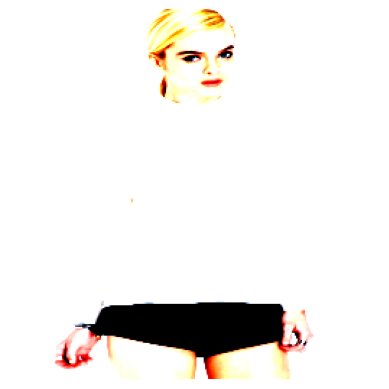

Sample 2:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg


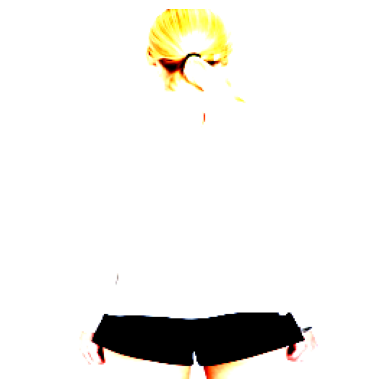

Sample 3:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg


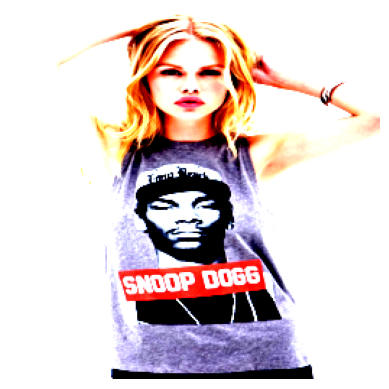

Sample 4:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_3_back.jpg


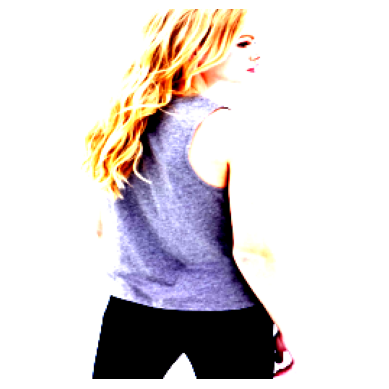

Sample 5:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Dresses/id_00000008/02_3_back.jpg


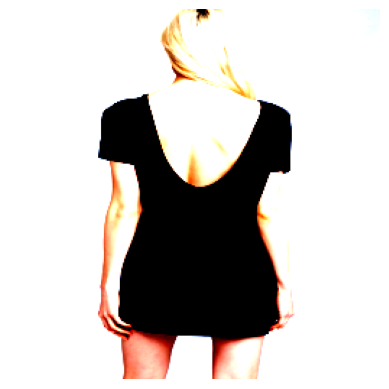

In [5]:
import matplotlib.pyplot as plt

# In ra số lượng ảnh trong dataset
print(f"Dataset có tổng cộng {len(gallery_dataset)} ảnh.")

# Lấy một vài ảnh từ dataset và hiển thị
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, image_name = dataset[i]  # Lấy cả ảnh và tên ảnh
        if image is None:  # Trường hợp có ảnh lỗi
            print(f"Ảnh ở index {i} bị lỗi.")
            continue
        print(f"Sample {i + 1}:")
        print(f"   Tensor size: {image.shape}")
        print(f"   Image Name: {image_name}")  # In ra tên ảnh

        # Hiển thị ảnh
        plt.imshow(image.permute(1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)
        plt.axis("off")
        plt.show()

# Hiển thị 5 mẫu ảnh
show_samples(gallery_dataset)


In [6]:
import torch.nn as nn
if EXTRACT_FEATURES:
    class Extractor(nn.Module):
        def __init__(self):
            super().__init__()
            self.l2norm = L2Norm()
            self.pool = GeM(p=3.0)  # Generalized Mean Pooling
            
        def forward(self, x):
            b, d, ny, nx = x.shape  # b=batch size, d=channels, ny, nx = spatial dimensions
            f0 = self.l2norm(self.pool(x)).view(b, 1, d)  # Normalize and reshape
            return f0


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

# Chỉnh sửa lớp cuối cùng hoặc cắt bỏ lớp FC sau khi tải trọng số
class CustomModel(nn.Module):
    def __init__(self, backbone, extractor=None):
        super(CustomModel, self).__init__()
        # Sử dụng backbone được tải trọng số từ archcut
        self.backbone = backbone
        self.extractor = extractor if extractor else nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.backbone(x)  # Feature maps từ backbone
        x = self.extractor(x)  # Pooling hoặc trích xuất đặc trưng
        return x


In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights

# Định nghĩa kiến trúc mô hình giống hệt khi huấn luyện
NUM_CLASSES = 3997  # Thay bằng số lớp bạn đã sử dụng khi huấn luyện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tạo kiến trúc mô hình
arch = resnet152(weights=None)  # Không tải trọng số mặc định
archcut = nn.Sequential(
    *list(arch.children())[:-2],          # Cắt bỏ FC layers
    nn.AdaptiveAvgPool2d(1),              # Pooling xuống 1x1
    nn.Flatten(),                         # Chuyển tensor thành vector
    nn.Linear(2048, NUM_CLASSES)          # Lớp FC cuối cùng
).to(device)

# Tải trọng số đã huấn luyện
trained_weight_path = "/kaggle/input/extractorresnet152/pytorch/default/1/extractorResnet152 (1).pth"  # Đường dẫn tới file đã lưu trọng số
state_dict = torch.load(trained_weight_path, map_location=device)
archcut.load_state_dict(state_dict)

print("Trọng số đã tải thành công vào mô hình!")
print(archcut)


/tmp/ipykernel_23/3096686534.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(trained_weight_path, map_location=device)


Trọng số đã tải thành công vào mô hình!
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_

In [10]:
backbone_weights = nn.Sequential(*list(archcut.children())[:-2])  # Lấy backbone đã có trọng số

In [12]:
# Tạo CustomModel với backbone và Extractor
extractor = Extractor()
model = CustomModel(backbone=backbone_weights, extractor=extractor).to(device)


In [13]:
print(model)

CustomModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [14]:
import os
import random
from torch.utils.data import Dataset
from PIL import Image

class customDataset2(Dataset):
    def __init__(self, root_dir, txt_path, transform=None, num_samples=100):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []
        selected_ids = set()  # Tập hợp để lưu các item_id đã được chọn

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name, item_id và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Duyệt qua file TXT để chọn ảnh duy nhất cho mỗi item_id
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]    # Đường dẫn ảnh từ TXT
            item_id = parts[1]       # Cột item_id
            evaluation_status = parts[2]

            # Chỉ chọn ảnh đầu tiên có trạng thái "query" cho mỗi item_id
            if evaluation_status == "query" and item_id not in selected_ids:
                if image_name in self.image_paths:  # Đảm bảo đường dẫn ảnh tồn tại
                    selected_ids.add(item_id)  # Thêm item_id vào set
                    self.data.append((image_name, self.image_paths[image_name]))

        # Lấy ngẫu nhiên 100 ảnh từ self.data (nếu đủ)
        self.data = random.sample(self.data, min(num_samples, len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None  # Bỏ qua nếu có lỗi khi đọc ảnh
        
        if self.transform:
            image = self.transform(image)
        
        return image, image_name


In [15]:
from torchvision import transforms
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

query_dataset = customDataset2(ROOT_DIR, CSV_PATH, transform = transform)

Dataset có tổng cộng 100 ảnh.
Sample 1:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00002330/03_1_front.jpg


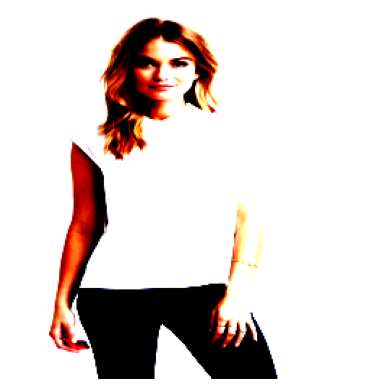

Sample 2:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Rompers_Jumpsuits/id_00001038/03_1_front.jpg


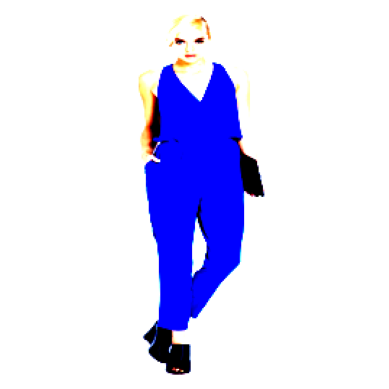

Sample 3:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Dresses/id_00002562/03_2_side.jpg


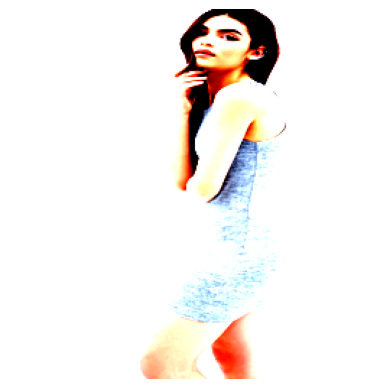

Sample 4:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00001325/02_2_side.jpg


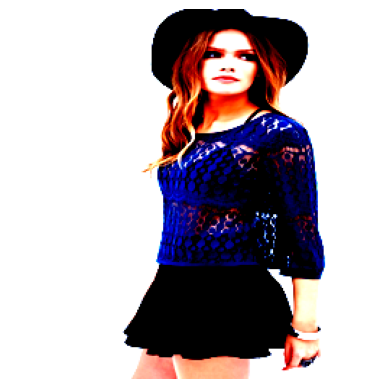

Sample 5:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Dresses/id_00005964/01_4_full.jpg


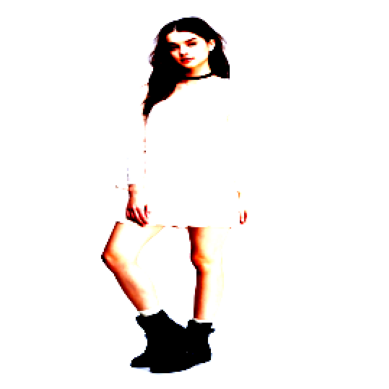

In [16]:
import matplotlib.pyplot as plt

# In ra số lượng ảnh trong dataset
print(f"Dataset có tổng cộng {len(query_dataset)} ảnh.")

# Lấy một vài ảnh từ dataset và hiển thị
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, image_name = dataset[i]  # Lấy cả ảnh và tên ảnh
        if image is None:  # Trường hợp có ảnh lỗi
            print(f"Ảnh ở index {i} bị lỗi.")
            continue
        print(f"Sample {i + 1}:")
        print(f"   Tensor size: {image.shape}")
        print(f"   Image Name: {image_name}")  # In ra tên ảnh

        # Hiển thị ảnh
        plt.imshow(image.permute(1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)
        plt.axis("off")
        plt.show()

# Hiển thị 5 mẫu ảnh
show_samples(query_dataset)


In [17]:
import torch
import numpy as np
from tqdm import tqdm

def extract_vectors_batched(dataloader, model, flip=False, device="cuda"):
    """
    Trích xuất vector đặc trưng từ mô hình theo từng batch.

    Args:
        dataloader: DataLoader PyTorch chứa dataset (images).
        model: Mô hình PyTorch để trích xuất vector.
        flip: Có áp dụng flipping để tăng cường dữ liệu hay không.
        device: Thiết bị thực thi ("cuda" hoặc "cpu").

    Returns:
        Tensor chứa vector đặc trưng cho tất cả ảnh, danh sách tên ảnh.
    """
    model.to(device)
    model.eval()

    n_flip = 2 if flip else 1  # Nếu flip, số ảnh mỗi batch sẽ gấp đôi
    n_img = len(dataloader.dataset) * n_flip  # Tổng số ảnh (bao gồm flipping nếu có)
    bs = dataloader.batch_size
    vectors = None  # Khởi tạo vector kết quả
    image_names = []  # Danh sách tên ảnh

    with torch.no_grad():
        for idx, (img_batch, img_names) in enumerate(tqdm(dataloader, desc="Extracting Features")):
            img_batch = img_batch.to(device)
            st = idx * bs * n_flip
            fin = min((idx + 1) * bs * n_flip, n_img)

            # Xử lý flipping nếu cần
            if flip:
                img_batch = torch.cat((img_batch, torch.flip(img_batch, dims=[3])), dim=0)  # Flip theo chiều ngang

            # Forward qua model
            out = model(img_batch).cpu()  # Chuyển output về CPU

            # Khởi tạo vector lưu kết quả trong lần lặp đầu tiên
            if vectors is None:
                vectors = torch.zeros(n_img, *out.shape[1:])

            # Ghi vector output vào vị trí tương ứng
            if flip:
                n = fin - st
                vectors[st:fin:2, ...] = out[:n // 2, ...]      # Ảnh gốc
                vectors[st + 1:fin + 1:2, ...] = out[n // 2:, ...]  # Ảnh flip
                image_names.extend([name for name in img_names] * 2)  # Lưu tên ảnh cho cả ảnh gốc và ảnh flip
            else:
                vectors[st:fin, ...] = out
                image_names.extend(img_names)  # Lưu tên ảnh

    return vectors, image_names

In [18]:
import os
import torch
from torch.utils.data import DataLoader
# Hàm trích xuất đặc trưng và lưu cache
def extract_and_cache_features(dataloader, model, feature_file, flip=False, device="cuda"):
    """
    Trích xuất và lưu các vector đặc trưng từ dataloader.

    Args:
        dataloader: PyTorch DataLoader.
        model: Mô hình trích xuất đặc trưng.
        feature_file: Tên file để lưu/tải vector đặc trưng.
        flip: Áp dụng flipping dữ liệu nếu True.
        device: Thiết bị thực thi ("cuda" hoặc "cpu").
    Returns:
        Tensor các vector đặc trưng.
    """
    p_flip = 'flip' if flip else ''  # Tạo tên file dựa trên flip

    # Kiểm tra file đã tồn tại hay chưa
    if os.path.exists(feature_file):
        print(f"Loading {feature_file} from disk...", end=" ")
        features = torch.load(feature_file)
        print("OK")
    else:
        print(f"Failed to load {feature_file}. Extracting features...")
        features = extract_vectors_batched(dataloader, model, flip=flip, device=device)
        torch.save(features, feature_file)
        print(f"Features saved to {feature_file}.")
    return features

# Đường dẫn lưu các file đặc trưng
# Đường dẫn lưu file trong Kaggle
output_dir = "/kaggle/working/"  # Lưu file tạm thời trong Kaggle Notebook

# Tạo đường dẫn đầy đủ cho file cache
query_feature_file = os.path.join(output_dir, "query_flip.pt")
train_feature_file = os.path.join(output_dir, "train_flip.pt")

# Model trích xuất đặc trưng
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tạo DataLoader cho query và train datasets
query_dataloader = DataLoader(query_dataset, batch_size=16, shuffle=False, num_workers=4)
gallery_dataloader = DataLoader(gallery_dataset, batch_size=16, shuffle=False, num_workers=4)


# Trích xuất hoặc load các vector đặc trưng
query_features, query_image_names = extract_vectors_batched(query_dataloader, model, flip=True, device=device)
gallery_features, gallery_image_names = extract_vectors_batched(gallery_dataloader, model, flip=True, device=device)

# In kết quả
print(f"Gallery features shape: {gallery_features.shape}")
print(f"Gallery image names: {gallery_image_names[:5]}")  # Hiển thị tên của 5 ảnh đầu tiên


Extracting Features: 100%|██████████| 789/789 [02:01<00:00,  6.47it/s]

Gallery features shape: torch.Size([25224, 1, 2048])
Gallery image names: ['WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_3_back.jpg', 'WOMEN/Dresses/id_00000008/02_3_back.jpg']


In [19]:
query_features, gallery_features

(tensor([[[2.1753e-08, 2.1753e-08, 2.1753e-08,  ..., 8.6024e-03,
           3.2804e-03, 1.0756e-02]],
 
         [[1.7198e-03, 5.9560e-04, 2.1548e-08,  ..., 4.9478e-03,
           5.8072e-04, 1.2340e-03]],
 
         [[2.5665e-08, 2.5665e-08, 5.7071e-03,  ..., 2.5665e-08,
           2.5665e-08, 1.6050e-02]],
 
         ...,
 
         [[1.5553e-03, 2.5080e-02, 2.4191e-02,  ..., 2.1432e-08,
           2.1432e-08, 1.8501e-02]],
 
         [[8.3354e-05, 2.5935e-08, 5.3216e-03,  ..., 8.2031e-04,
           2.5839e-02, 5.9142e-04]],
 
         [[1.9499e-04, 2.5128e-08, 1.3784e-03,  ..., 4.0315e-03,
           3.0766e-02, 2.4935e-04]]]),
 tensor([[[1.8157e-08, 7.6614e-02, 1.8157e-08,  ..., 4.6691e-04,
           6.4140e-03, 2.7853e-02]],
 
         [[1.3461e-05, 7.6135e-02, 1.8678e-08,  ..., 1.8678e-08,
           5.6004e-03, 3.0372e-02]],
 
         [[2.0771e-08, 9.1694e-02, 2.0771e-08,  ..., 2.0771e-08,
           7.4715e-03, 2.6984e-02]],
 
         ...,
 
         [[4.9281e-03, 1.3197e-0

In [20]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 21.4 MB/s eta 0:00:00:00:0100:01


In [21]:
import faiss
import itertools
from pathlib import Path

# Hàm flatten dùng để làm phẳng danh sách 2 chiều
def flatten(list2d):
    return list(itertools.chain(*list2d))

# Lấy đường dẫn ảnh từ dataset (không rút gọn tên ảnh)
query_fnames = flatten([[image_name,image_name] for _, image_name in query_dataset])
index_fnames = flatten([[image_name,image_name] for _, image_name in gallery_dataset])

print("Query file paths:", query_fnames[:5])   # In ra 5 đường dẫn đầu tiên trong query_fnames
print("Index file paths:", index_fnames[:5])   # In ra 5 đường dẫn đầu tiên trong index_fnames


Query file paths: ['WOMEN/Blouses_Shirts/id_00002330/03_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00002330/03_1_front.jpg', 'WOMEN/Rompers_Jumpsuits/id_00001038/03_1_front.jpg', 'WOMEN/Rompers_Jumpsuits/id_00001038/03_1_front.jpg', 'WOMEN/Dresses/id_00002562/03_2_side.jpg']
Index file paths: ['WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg']


In [22]:
import numpy as np
def t_pcawhitenlearn(X):
    N = X.shape[0]

    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2 * N)
    
    # Thay thế torch.symeig bằng torch.linalg.eigh
    eigval, eigvec = torch.linalg.eigh(Xcov)
    
    # Sắp xếp giá trị riêng và vectơ riêng theo thứ tự giảm dần
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    # Tính ma trận làm trắng P
    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()

    return m, P

def t_whitenapply(X, m, P, dimensions=None):

    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X

def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):

    if True:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P,dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P,dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
         _index_features = _index_features.unsqueeze(1)
         _query_features = _query_features.unsqueeze(1)

    if isinstance(_query_features, torch.Tensor): query_features = _query_features.numpy()
    if isinstance(_index_features, torch.Tensor): index_features = _index_features.numpy()
    max_hits = 20

    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    print(query_features.shape, index_features.shape, n_queries, n_patches)

    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.device = 0
    res = faiss.StandardGpuResources()
    co = faiss.GpuMultipleClonerOptions()
    co.shard=True
    co.shard_type=1
    co.useFloat16=False
    index_features = index_features.squeeze(1)  # Remove the extra singleton dimension
    query_features = query_features.squeeze(1)  # Remove the extra singleton dimension
    print(index_features.shape)  # Should print (num_samples, num_dimensions)
    print(query_features.shape)  # Should print (num_queries, num_dimensions)
    _index = faiss.index_factory(index_features.shape[1], index_type)#, faiss.METRIC_INNER_PRODUCT)
    try:
        index = _index #faiss.index_cpu_to_all_gpus(_index,co=co) #
        print("Index in GPU")
    except:
        index = _index
        print("Index in CPU")
    print("Training index...", end="")
    index.train(index_features)
    print("done")
    print("Adding features to index...", end="")
    index.add(index_features)
    print("done")
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len (query_features)
    for ind in progress_bar(range(0, len(query_features), BS)):
        fin = ind+BS
        if fin > NUM_QUERY: fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    return out_idxs, out_dists

In [24]:
import faiss
import numpy as np
from tqdm import tqdm
import re
def t_pcawhitenlearn(X):
    N = X.shape[0]

    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2 * N)
    
    # Thay thế torch.symeig bằng torch.linalg.eigh
    eigval, eigvec = torch.linalg.eigh(Xcov)
    
    # Sắp xếp giá trị riêng và vectơ riêng theo thứ tự giảm dần
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    # Tính ma trận làm trắng P
    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()

    return m, P

def t_whitenapply(X, m, P, dimensions=None):

    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X
def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):

    if True:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P, dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P, dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: 
                index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
        _index_features = _index_features.unsqueeze(1)
        _query_features = _query_features.unsqueeze(1)

    if isinstance(_query_features, torch.Tensor): 
        query_features = _query_features.numpy()
    if isinstance(_index_features, torch.Tensor): 
        index_features = _index_features.numpy()
    
    max_hits = 20
    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    print(query_features.shape, index_features.shape, n_queries, n_patches)
    index_features = index_features.squeeze(1)  # Remove the extra singleton dimension
    query_features = query_features.squeeze(1)  # Remove the extra singleton dimension
    print(index_features.shape[1])
    # Chọn IVF với Product Quantization (PQ)
    nlist = 1024  # số nhóm (clusters)
    nsubquantizers = 16  # Số sub-quantizers
    nbits = 8  # Số bits cho mỗi sub-quantizer

    # Tạo quantizer (sử dụng IndexFlatL2 làm quantizer)
    quantizer = faiss.IndexFlatL2(index_features.shape[1])

    # Tạo chỉ mục IVF với PQ
    index = faiss.IndexIVFPQ(quantizer, index_features.shape[1], nlist, nsubquantizers, nbits)
    
    # Huấn luyện chỉ mục IVF với PQ
    print("Training index...", end="")
    index.train(index_features)  # Huấn luyện với dữ liệu mẫu
    print("done")

    # Thêm các đặc trưng vào chỉ mục IVF với PQ
    print("Adding features to index...", end="")
    index.add(index_features)  # Thêm các đặc trưng vào chỉ mục
    print("done")
    
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len(query_features)

    # Tìm kiếm trong chỉ mục IVF với PQ
    for ind in tqdm(range(0, len(query_features), BS), desc="Querying FAISS index"):
        fin = ind + BS
        if fin > NUM_QUERY: 
            fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    
    return out_idxs, out_dists


In [25]:
faiss.omp_get_max_threads()

2

In [27]:
# Squeeze out the singleton dimensions
gallery_features = gallery_features.squeeze(1).squeeze(1)  # Remove the extra singleton dimensions
query_features = query_features.squeeze(1).squeeze(1)  # Remove the extra singleton dimensions

print("Shape of index_features:", gallery_features.shape)  # Should print (25224, 2048)
print("Shape of query_features:", query_features.shape)  # Should print (num_queries, 2048)

Shape of index_features: torch.Size([25224, 2048])
Shape of query_features: torch.Size([200, 2048])


In [42]:
#faiss.omp_set_num_threads(31)
index_type=f"PCAW{query_features.shape[-1]},L2norm,Flat"
#index_type="PCAW512,L2norm,IVF4096,PQ16"
#index_type="Flat"

#out_idxs, out_dists = get_idxs_and_dists(
#    torch.cat((query_features[0],query_features[1]),dim=-1).squeeze(1),
#    torch.cat((index_features[0],index_features[1]),dim=-1).squeeze(1), BS = 32*4, index_type=index_type)
out_idxs, out_dists = get_idxs_and_dists(
    query_features,
    gallery_features, index_type=index_type, BS = 32*4 )

Applying 2048 PCA, Whitening and L2Norm...done
Flat
(200, 1, 2048) (25224, 1, 2048) 200 1
(25224, 2048)
(200, 2048)
Index in GPU
Training index...done
Adding features to index...done


In [28]:
#faiss.omp_set_num_threads(31)
index_type=f"PCAW{query_features.shape[-1]},L2norm,IVF4096"
#index_type="PCAW512,L2norm,IVF4096,PQ16"
#index_type="Flat"

#out_idxs, out_dists = get_idxs_and_dists(
#    torch.cat((query_features[0],query_features[1]),dim=-1).squeeze(1),
#    torch.cat((index_features[0],index_features[1]),dim=-1).squeeze(1), BS = 32*4, index_type=index_type)
out_idxs, out_dists = get_idxs_and_dists(
    query_features,
    gallery_features, index_type=index_type, BS = 32*4 )

Applying 2048 PCA, Whitening and L2Norm...done
IVF4096
(200, 1, 2048) (25224, 1, 2048) 200 1
2048
Training index...

WARNING clustering 25224 points to 1024 centroids: please provide at least 39936 training points


done
Adding features to index...done


Querying FAISS index: 100%|██████████| 2/2 [00:00<00:00, 30.32it/s]


In [29]:
np.sort(out_dists.reshape((-1,int(out_idxs.shape[1]*1))), axis=1)

array([[3.8524389e-01, 4.2867556e-01, 5.2014232e-01, ..., 6.7171019e-01,
        6.8112016e-01, 7.0343131e-01],
       [4.0282696e-01, 4.6589977e-01, 4.8946807e-01, ..., 7.1988708e-01,
        7.3179436e-01, 7.4615717e-01],
       [3.6417678e-01, 3.6855406e-01, 3.7284213e-01, ..., 7.5436372e-01,
        7.6743400e-01, 9.2075586e-01],
       ...,
       [6.4357388e-01, 6.9796520e-01, 7.2497666e-01, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [4.7794876e-01, 5.4249024e-01, 7.4580991e-01, ..., 9.0285558e-01,
        9.0445888e-01, 9.0798777e-01],
       [3.8039652e-01, 4.8505846e-01, 6.6185755e-01, ..., 8.1656390e-01,
        8.2395661e-01, 8.3663797e-01]], dtype=float32)

In [84]:
np.save(f'idx.npy',  out_idxs)
np.save(f'dist.npy', out_dists)

In [30]:
import os
import csv

# Đọc file TXT chứa thông tin ảnh
txt_path = '/kaggle/input/deepfashion1/updated_list_eval_partition.txt'  # Đường dẫn tới file TXT
root_dir = '/kaggle/input/deepfashion1/images'  # Đường dẫn tới thư mục chứa ảnh (nếu cần)

# Tạo danh sách chứa các ảnh có evaluation_status = "query"
data = []

with open(txt_path, 'r') as f:
    lines = f.readlines()

# Bỏ qua dòng đầu tiên và header
for line in lines[2:]:
    parts = line.strip().split()
    image_name = parts[0]  # Tên ảnh
    evaluation_status = parts[2]  # Trạng thái đánh giá

    # Kiểm tra nếu evaluation_status = "query"
    if evaluation_status == "query":
        # Thêm image_name vào danh sách
        data.append(image_name)

# Đặt tên file và lưu query.csv
output_file = '/kaggle/working/query.csv'  # Đường dẫn nơi file sẽ được lưu

with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['images']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Ghi header
    writer.writeheader()

    # Ghi từng dòng dữ liệu
    for image_name in data:
        writer.writerow({'images': image_name})

print(f"query.csv đã được tạo thành công và lưu tại {output_file}.")


query.csv đã được tạo thành công và lưu tại /kaggle/working/query.csv.


In [33]:
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('query.csv')
sample_df['images'] = ''

In [34]:
out_idxs[0]//2, out_idxs[1]//2

(array([ 3697,  3696,  3990,  3696,  2254,  3992,  6016,  3991,  2734,
         6016,   740,  4142,  2254, 11644,  2253, 11645, 11729, 11644,
         4142,  2253], dtype=int32),
 array([ 3696,  3697,  3696,  2253,  3990,  3992,  3991,  6016,  2254,
         2734,  2254, 11644,  6016,  2734, 11645,  4142,   740,  8871,
         8871, 11645], dtype=int32))

In [35]:
i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]]//2)

i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]])

[ 3014  3015  3016  3017  4790  3020  3018  3021  4530  4792  4791 19967
  3019  4793  4532 19966  4533  4531  4535  4529  3015  3017  3014  3021
  3016  4791  3020  3018 19967  3019  4790  4530  4793  4531  4533 19966
  4792  4532  4535  4529] [ 0  1  2  3 14  6  4  7  9 16 15 19  5 17 11 18 12 10 13  8] [0.36417678 0.36855406 0.37284213 0.49345914 0.5393108  0.63138497
 0.5350421  0.5551882  0.92075586 0.60079426 0.7543637  0.6555519
 0.72950023 0.767434   0.5277462  0.611295   0.6062651  0.6447516
 0.7018565  0.6224396 ]
[1507 1507 1508 1508 2395 1510 1509 1510 2265 2396 2395 9983 1509 2396
 2266 9983 2266 2265 2267 2264]
[1507 1507 1508 1508 2395 1510 1509 1510 2265 2396 2395 9983 1509 2396
 2266 9983 2266 2265 2267 2264 1507 1508 1507 1510 1508 2395 1510 1509
 9983 1509 2395 2265 2396 2265 2266 9983 2396 2266 2267 2264] [ 0  1  8  3  2  5  9 10  6  7  4] [0.36417678 0.37284213 0.5393108  0.5350421  0.92075586 0.60079426
 0.6555519  0.767434   0.5277462  0.6062651  0.6224396 ]
[150

In [36]:
sub = {}
for i, query_fname in progress_bar(enumerate(query_fnames), total=len(query_fnames)):
    if i % 2: continue
    
    # Kiểm tra để tránh vượt quá chỉ mục
    if i + 1 >= len(out_idxs):  # Nếu i+1 vượt quá kích thước mảng, bỏ qua
        continue
    
    idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
    dst = np.concatenate([out_dists[i], out_dists[i+1]], axis=0)
    
    u_idx = np.unique(idx, return_index=True)[1]
    i_dst = dst[u_idx]
    o_dst = np.argsort(i_dst)
    _out_idxs = idx[u_idx[o_dst]]

    ids = [index_fnames[x*2] for x in _out_idxs[:10]]
    sub[query_fname] = ' '.join(ids)


In [37]:
sub_df = pd.DataFrame({'id' : list(sub.keys()), 'images':list(sub.values())})
sub_df = pd.concat([sub_df, sample_df]).drop_duplicates(subset=['id'])
sub_df.to_csv(sub_fname, index=False)

In [38]:
sub_df.iloc[:8]

id  \
0    WOMEN/Blouses_Shirts/id_00002330/03_1_front.jpg   
1  WOMEN/Rompers_Jumpsuits/id_00001038/03_1_front...   
2            WOMEN/Dresses/id_00002562/03_2_side.jpg   
3     WOMEN/Blouses_Shirts/id_00001325/02_2_side.jpg   
4            WOMEN/Dresses/id_00005964/01_4_full.jpg   
5      WOMEN/Dresses/id_00003833/02_7_additional.jpg   
6        WOMEN/Tees_Tanks/id_00007925/01_1_front.jpg   
7     WOMEN/Sweaters/id_00000464/02_7_additional.jpg   

                                              images  
0  WOMEN/Blouses_Shirts/id_00002330/03_4_full.jpg...  
1  WOMEN/Rompers_Jumpsuits/id_00001038/03_2_side....  
2  WOMEN/Dresses/id_00002562/03_1_front.jpg WOMEN...  
3  WOMEN/Blouses_Shirts/id_00001325/02_1_front.jp...  
4  WOMEN/Dresses/id_00005964/01_1_front.jpg WOMEN...  
5  WOMEN/Blouses_Shirts/id_00000108/03_7_addition...  
6  WOMEN/Tees_Tanks/id_00002927/07_7_additional.j...  
7  WOMEN/Sweaters/id_00000464/02_3_back.jpg WOMEN...

## Flat

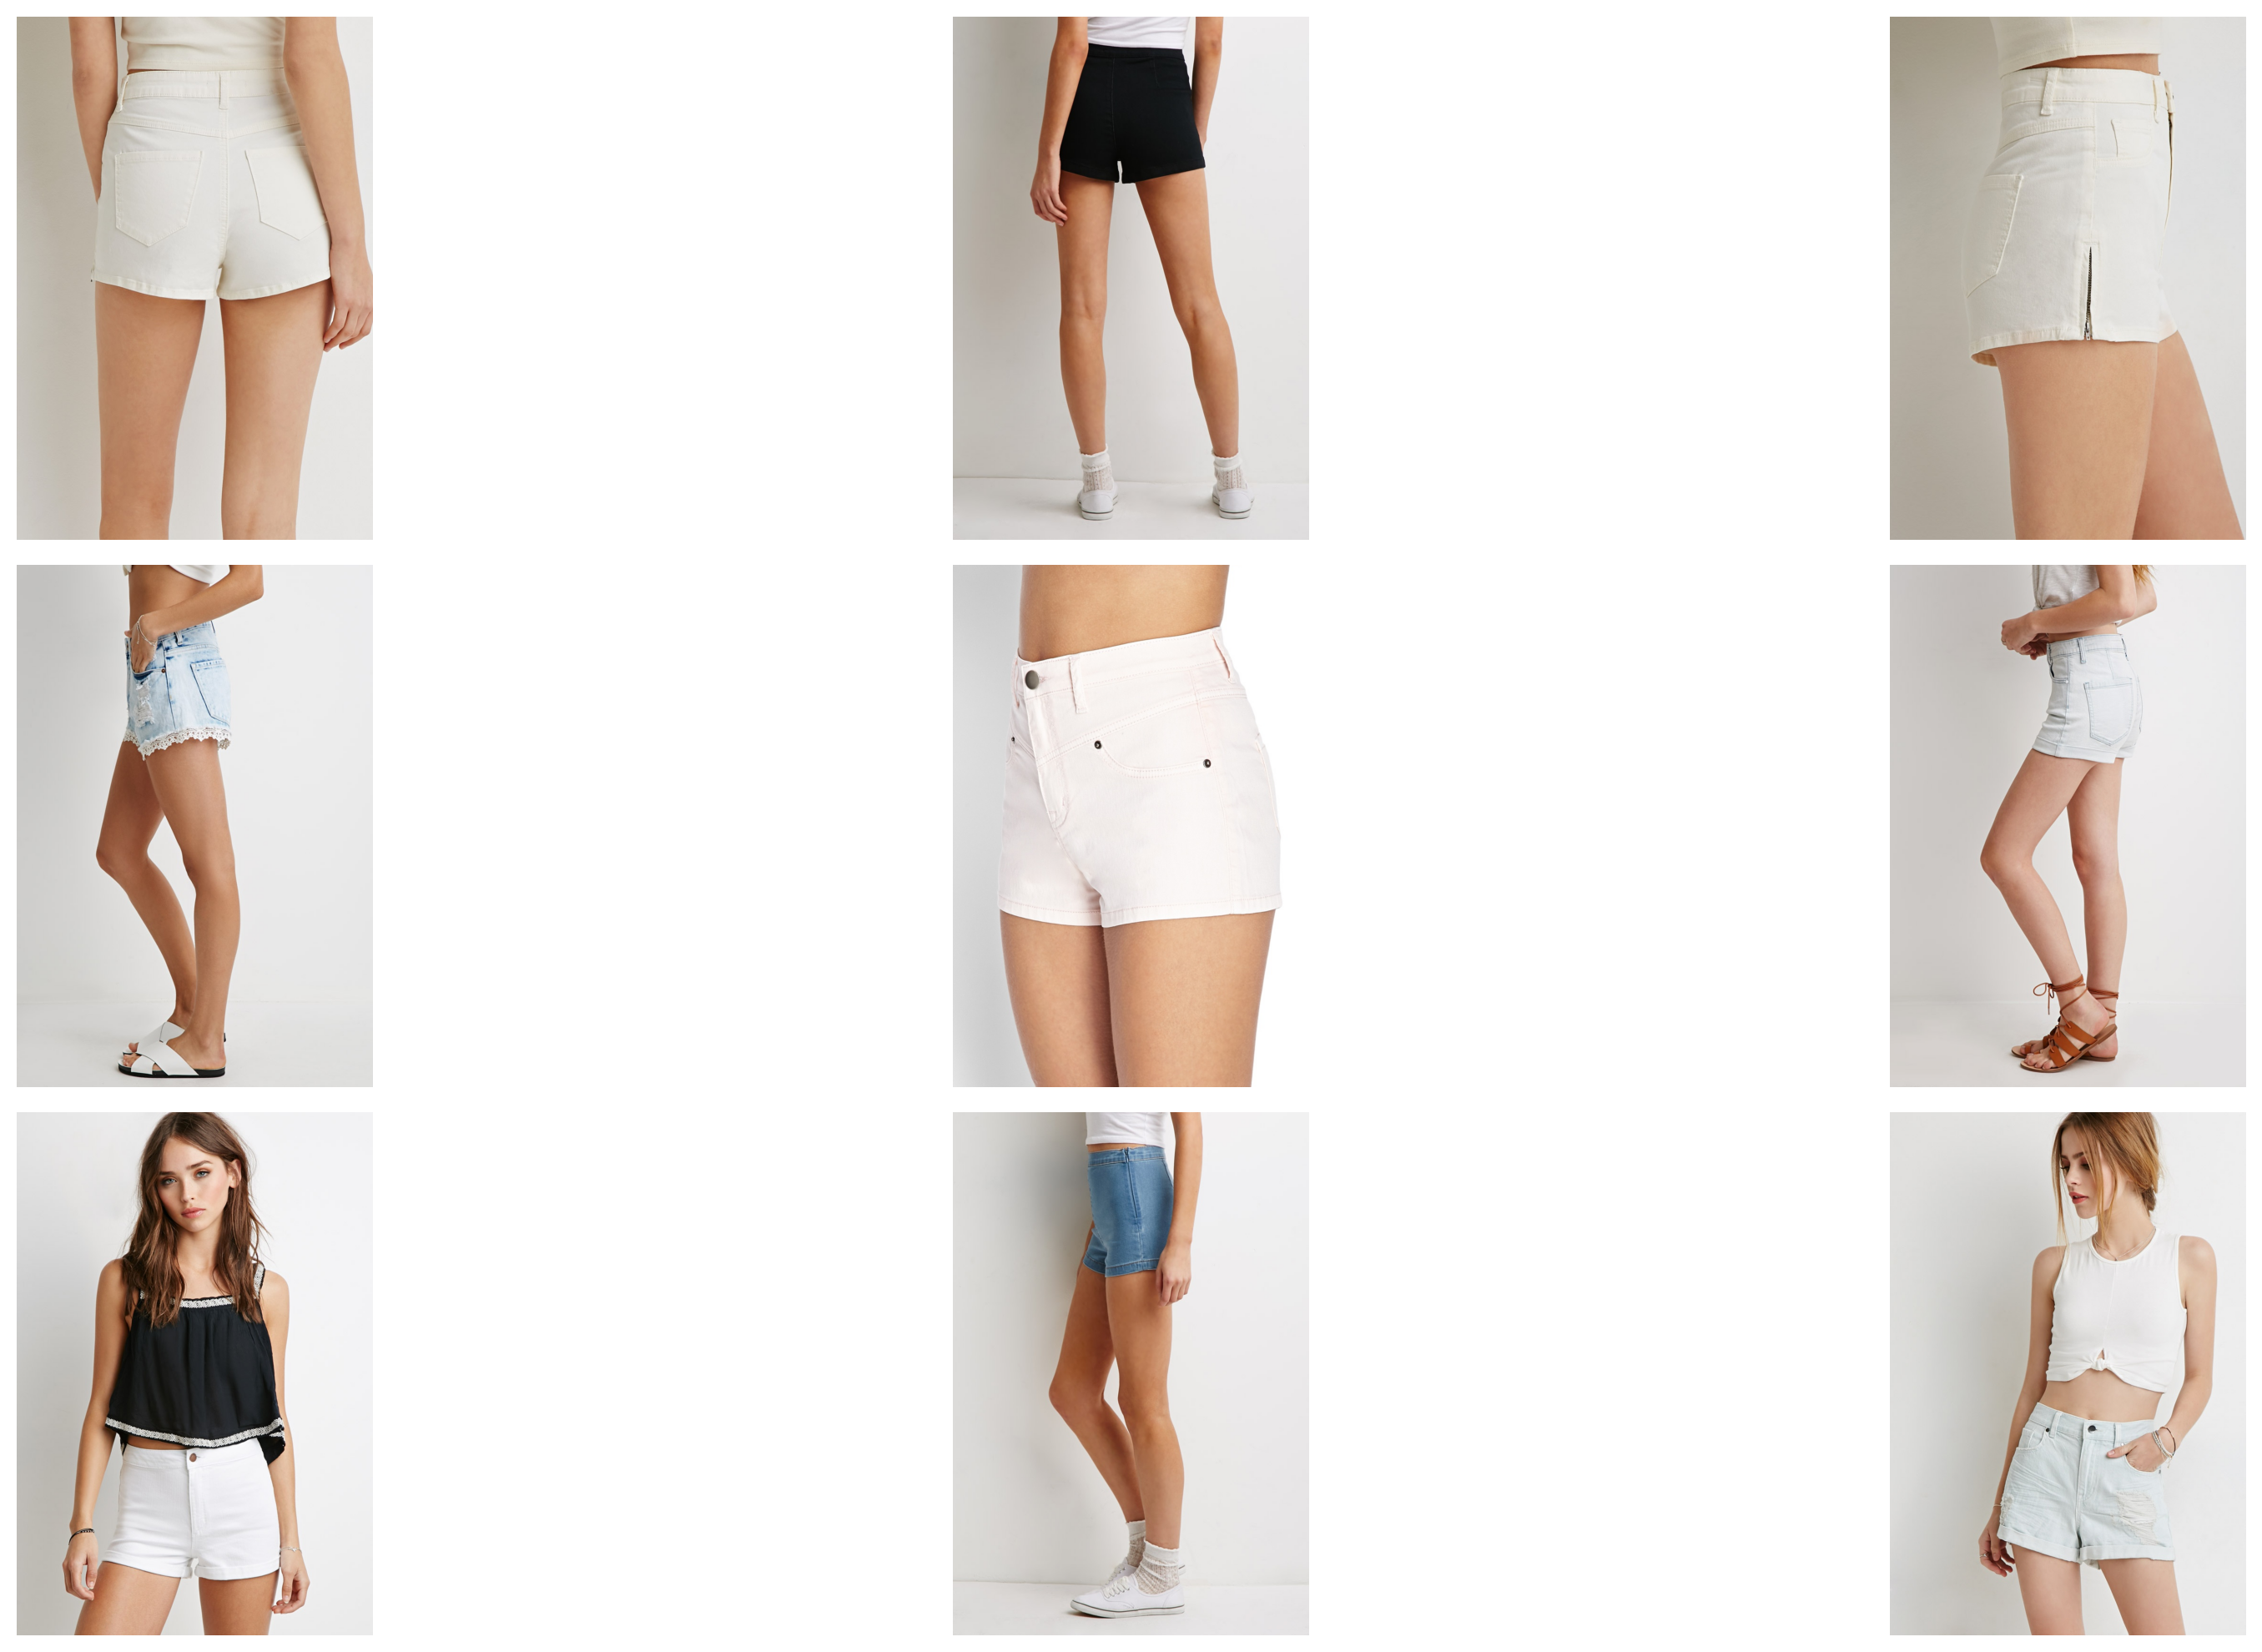

In [54]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def fix_path(p):
    # Lấy tên tệp tin
    fn = str(p.name)
    
    # Kiểm tra xem p có "WOMEN" hoặc "MEN" ở phần đầu hay không
    if p.parts[0] == "WOMEN":
        return Path("/kaggle/input/deepfashion1/WOMEN") / p  # Nếu là "WOMEN", thêm "WOMEN"
    elif p.parts[0] == "MEN":
        return Path("/kaggle/input/deepfashion1/MEN") / p  # Nếu là "MEN", thêm "MEN"
    else:
        return Path("/kaggle/input/deepfashion1") / p  # Trường hợp khác, giữ nguyên

# Hàm lấy ảnh và kết quả từ dataframe
def image_results(row, n=9):  # Change n to 9 for 9 images
    # 9 ảnh kết quả từ cột 'images' (bao gồm cả ảnh query đầu tiên)
    result_images = [Image.open(fix_path(Path(id))).convert("RGB") for id in row.images.split(' ')[:n]]

    return result_images

# Hàm để hiển thị các ảnh
def show_all(images, r=3, c=3, figsize=(20, 10)):  # Update r and c to fit 3 rows and 3 columns
    fig, axs = plt.subplots(r, c, figsize=figsize)  # Tạo lưới subplots (3 rows, 3 columns)
    axs = axs.flatten()  # Chuyển thành mảng 1 chiều để dễ thao tác

    # Duyệt qua và hiển thị các ảnh
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')  # Tắt hiển thị trục của ảnh

    plt.tight_layout()  # Căn chỉnh các ảnh hợp lý
    plt.show()

# Ví dụ sử dụng show_all với dataframe
# Hiển thị ảnh của row thứ 3 trong dataframe sub_df, bao gồm cả ảnh query (ảnh đầu tiên)
show_all(image_results(sub_df.iloc[1], n=9), r=3, c=3, figsize=(20, 10))


## IVF

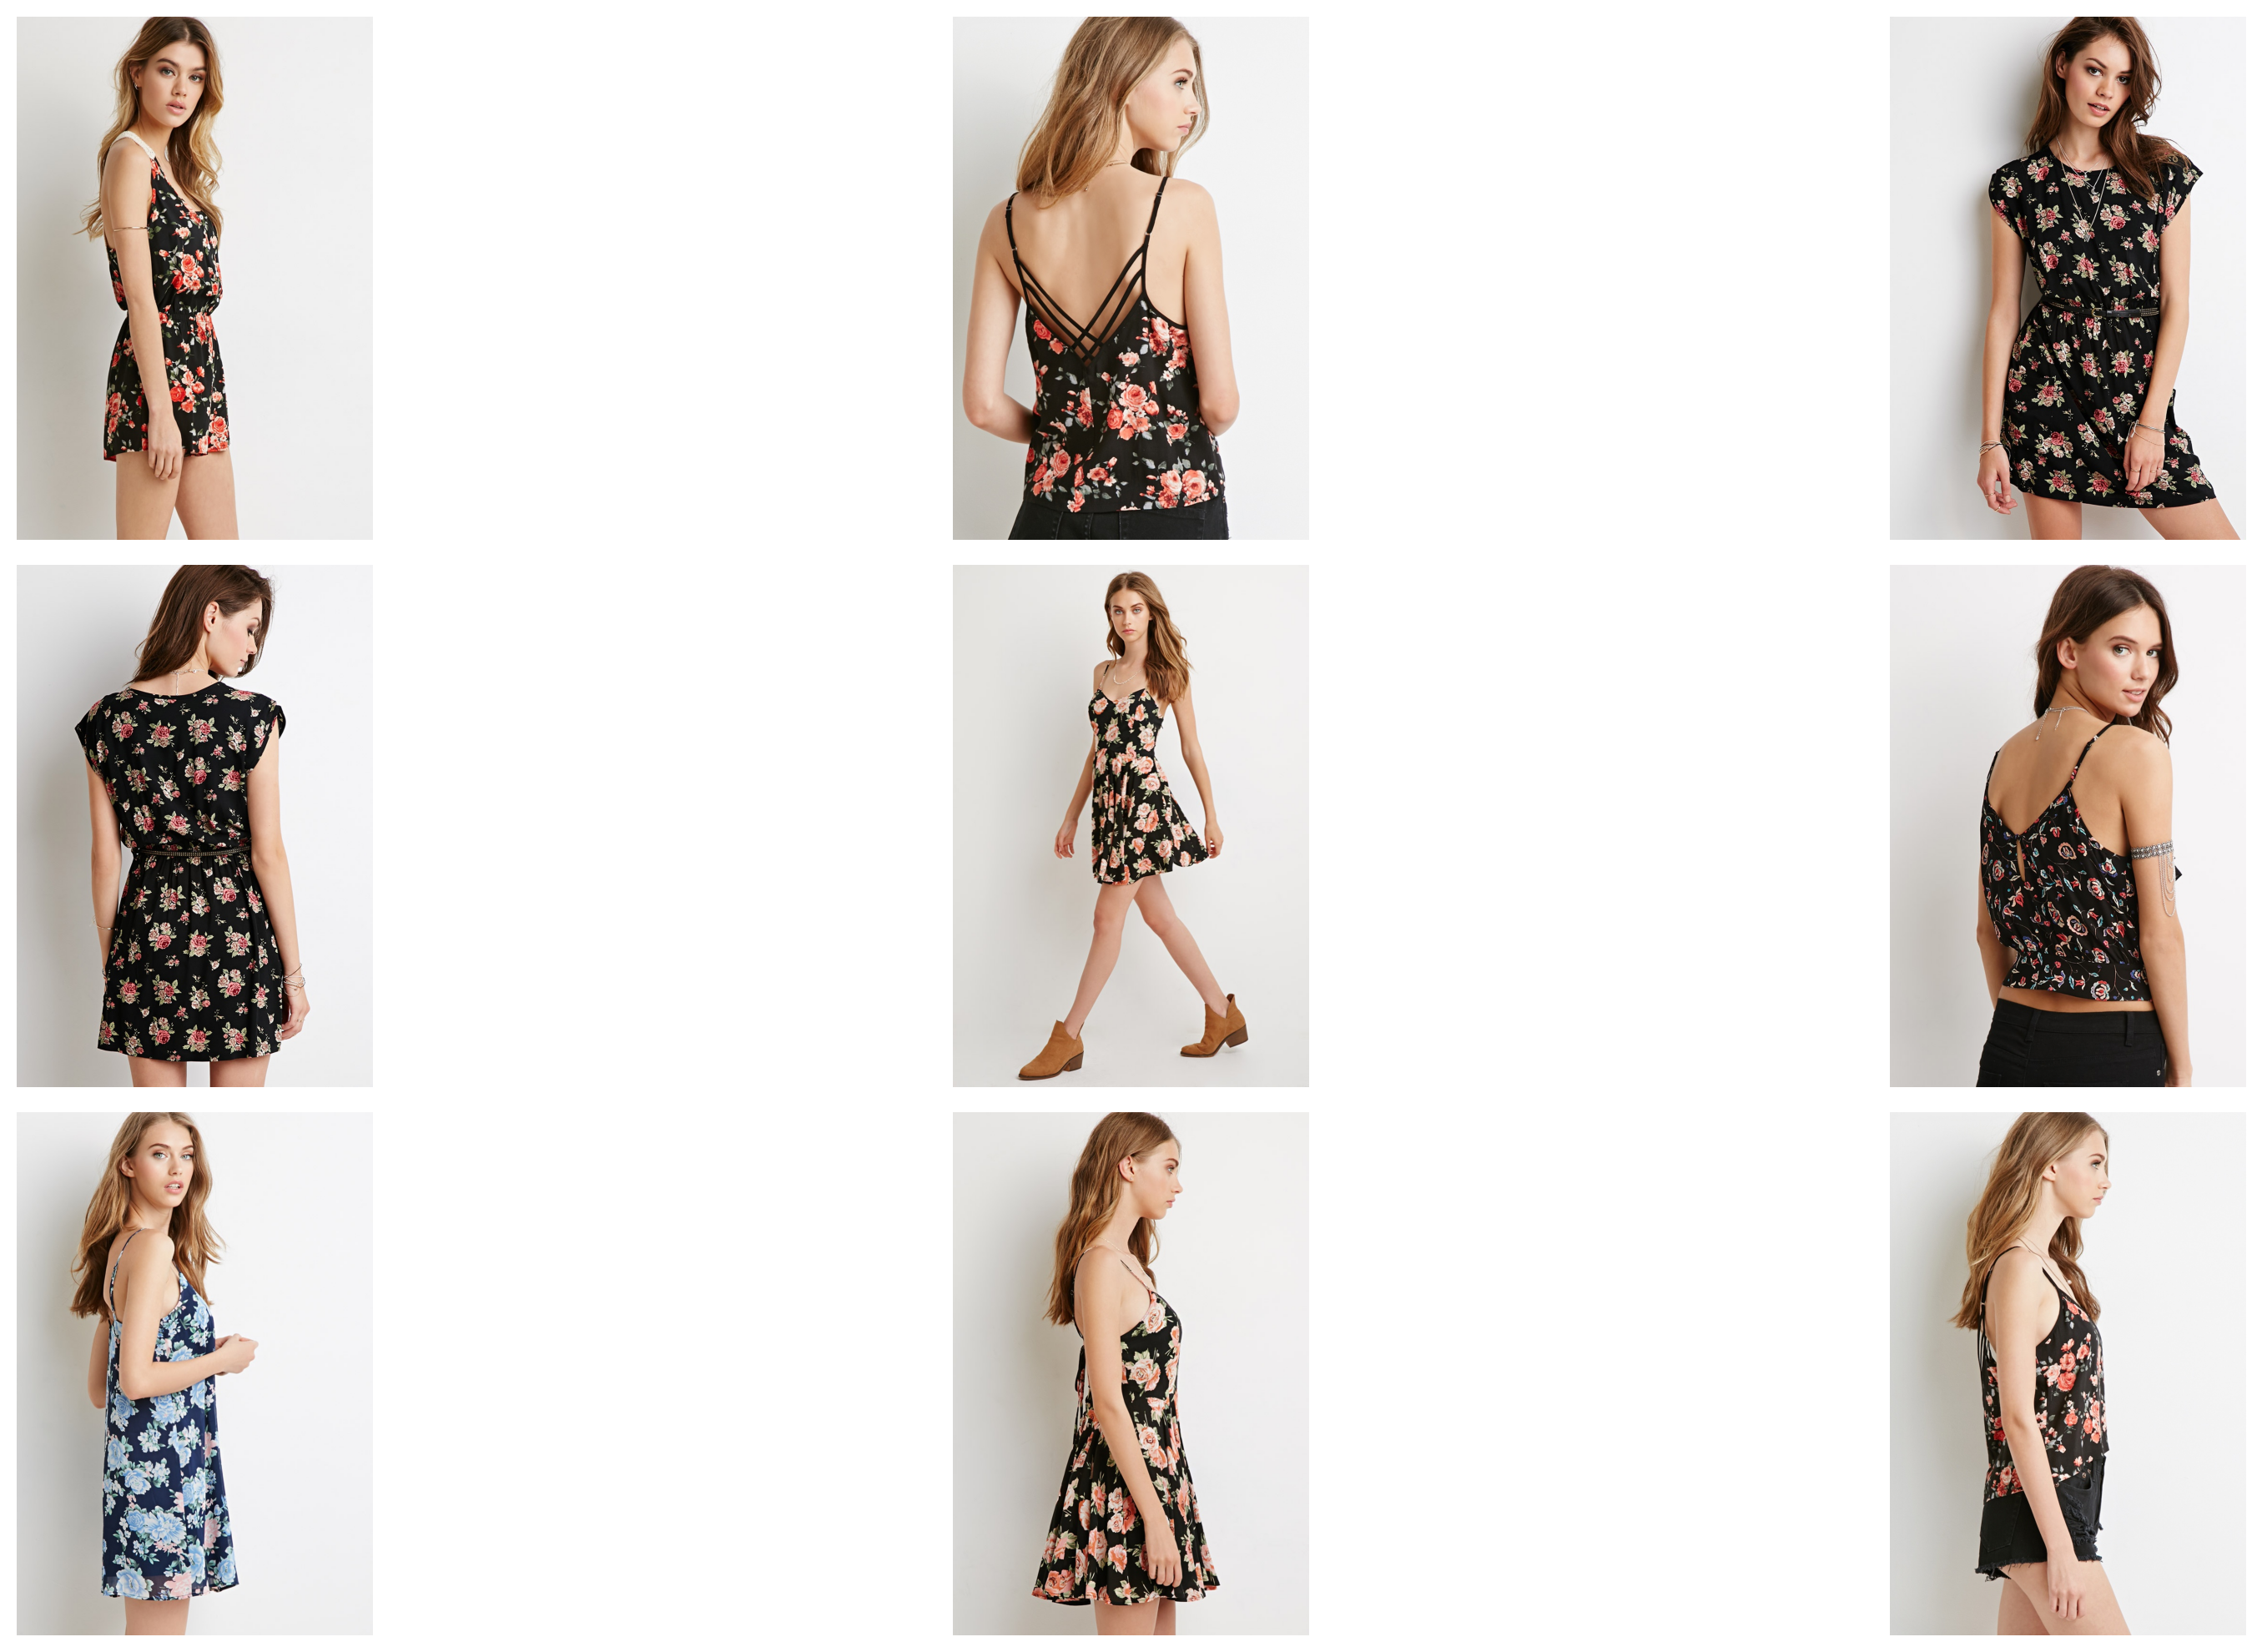

In [47]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def fix_path(p):
    # Lấy tên tệp tin
    fn = str(p.name)
    
    # Kiểm tra xem p có "WOMEN" hoặc "MEN" ở phần đầu hay không
    if p.parts[0] == "WOMEN":
        return Path("/kaggle/input/deepfashion1/WOMEN") / p  # Nếu là "WOMEN", thêm "WOMEN"
    elif p.parts[0] == "MEN":
        return Path("/kaggle/input/deepfashion1/MEN") / p  # Nếu là "MEN", thêm "MEN"
    else:
        return Path("/kaggle/input/deepfashion1") / p  # Trường hợp khác, giữ nguyên

# Hàm lấy ảnh và kết quả từ dataframe
def image_results(row, n=9):  # Change n to 9 for 9 images
    # 9 ảnh kết quả từ cột 'images' (bao gồm cả ảnh query đầu tiên)
    result_images = [Image.open(fix_path(Path(id))).convert("RGB") for id in row.images.split(' ')[:n]]

    return result_images

# Hàm để hiển thị các ảnh
def show_all(images, r=3, c=3, figsize=(20, 10)):  # Update r and c to fit 3 rows and 3 columns
    fig, axs = plt.subplots(r, c, figsize=figsize)  # Tạo lưới subplots (3 rows, 3 columns)
    axs = axs.flatten()  # Chuyển thành mảng 1 chiều để dễ thao tác

    # Duyệt qua và hiển thị các ảnh
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')  # Tắt hiển thị trục của ảnh

    plt.tight_layout()  # Căn chỉnh các ảnh hợp lý
    plt.show()

# Ví dụ sử dụng show_all với dataframe
# Hiển thị ảnh của row thứ 3 trong dataframe sub_df, bao gồm cả ảnh query (ảnh đầu tiên)
show_all(image_results(sub_df.iloc[9], n=9), r=3, c=3, figsize=(20, 10))
